In [1]:
import pandas as pd
import numpy as np

# Import and processing data
df = pd.read_csv("transactions.csv")
df["MonthYear"] = df["Date"].str.slice(2)
df["Day"] = df["Date"].str.slice(0,2)
n_tran = []
for i, group in df.groupby("MonthYear"):
    n_tran.append(len(group))
    
# Number of transactions in a month
n_tran = np.array(n_tran)
# Days of the month in which transactions take place
days = np.array(df["Day"]).astype(np.int_)
# Transaction size
tran_size = np.array(df["Amount"]).astype(np.float)

In [2]:
# Function for building and plotting density models
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
def density_model(data,title, 
                  params=[(5, 'gaussian'),(5, 'tophat'),(5, 'epanechnikov')], 
                  show_data=True):
    N = len(data)
    X = data
    X = X.reshape(len(X),1)

    X_plot = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
    fig, ax = plt.subplots()
    models = {}
    for bandwidth, kernel in params:
        kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(X)
        log_dens = kde.score_samples(X_plot)
        ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
                label="ker='{0}' width={1}".format(kernel[:3],bandwidth))
        models[(bandwidth, kernel)] = kde

    plt.title("N={0} points".format(N))
    plt.suptitle(title)

    ax.legend(loc='upper right')
    if show_data:
        max_y = np.max(np.exp(log_dens))
        ax.plot(X[:, 0], 
                -(max_y*0.025) - (max_y*0.05) * np.random.random(X.shape[0]), 
                '+k')

    plt.show()
    return models

# Number of transactions that occur in a single month

**Kernel selection**: The number of transactions that occur in a single month is likely a Poisson distribution and therefore smooth. I chose Gaussian kernel for density estimation because of its smoothness and mathematical convenience. I didn't choose epanechnikov kernel because the sampling function for that kernel has not been implemented in Scipy (only tophat and gaussian can be sampled) and therefore would be inconvenient for later tasks. However, I showed that gaussian and epanechnikov kernels give very similar results when using appropriate bandwidths (Figure 2, Supplementary Materials).

**Bandwidth selection**: When selecting an appropriate bandwidth, we need to avoid oversmoothing (green curve) and undersmoothing (blue curve). The orange curve with bandwidth=10 is ideal.

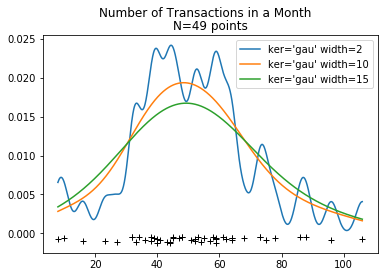

In [3]:
n_tran_models = density_model(n_tran,"Number of Transactions in a Month",
                    params=[(2, 'gaussian'), (10, 'gaussian'),(15, 'gaussian')])

# Day in the month that a transaction will occur on

There is no strong justification for the smoothness assumption in the distribution of transaction days. For example, if a lot of automatic payments are scheduled on the fifth day of the month, there would be a peak at day=5 in the actual distribution. However, it is quite likely that the bins at day=4 and day=6 are not similar to day=5 and have much lower values. In this case, if we try to fit a smooth curve in this area, we would falsely neutralize the peak at day=5.

Looking at the histogram, it's also not obvious that there is an underlying smooth distribution, given the high fluctuations that we observe. 

Therefore, kernel density estimation is not necessary and I simply used **normed histogram** (each day is a bin) as my model.

Also, if we simply use a plain kernel density estimation, it might inaccurately portrait the two ends of the distribution since it does not take the cyclic property of the data into account (for example, not knowing that day=31 and day=1 are close and similar).

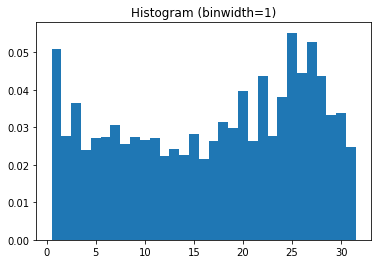

In [4]:
freq, bins, _ = plt.hist(days, bins=np.arange(0.5,32.5), normed=True)
plt.title("Histogram (binwidth=1)")
plt.show()

# Transaction size

**Data Transformation**: The original data distribution for transaction amounts is extremely long-tailed and therefore kernel density estimation did not perform very well (See Figure 1, Supplementary Material). Therefore, I transformed data into log-scale($-\log(-x)$ for negative values). 

**Kernel selection**: I chose Gaussian kernel for similar reasons as Section 1. I also compared the performance of gaussian and epanechnikov kernels in Figure 3, Supplementary Materials.

**Bandwidth selection**: Using similar principles as Section 1, the orange curve with bandwidth=0.25 is selected.

In [7]:
# Transform data into log-scale
sign = (((tran_size>0)-0.5)*2).astype(np.int_)
tran_size_logged = sign * np.log10(np.abs(tran_size))

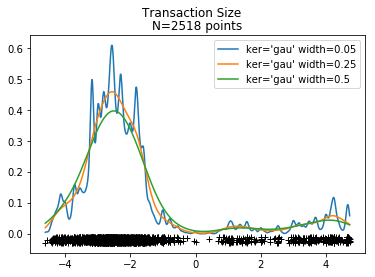

In [8]:
tran_size_models = density_model(tran_size_logged,"Transaction Size", 
                       params=[(0.05, 'gaussian'), (0.25, 'gaussian'),(0.5, 'gaussian')])

# Generate fictitious data

In [14]:
import pandas as pd
def generate_fake_data(n_tran_model, days_model, tran_size_model):
    # Generate the number of transactions in a month
    n_transactions = max(0, int(np.round(n_tran_model.sample())))
    dates = []
    amounts = []
    # For each transaction
    for i in range(n_transactions):
        # Generate fake date
        d = int(np.random.choice(range(1,32), p=days_model))
        dates.append(d)
        # Generate fake amount
        logged_a = tran_size_model.sample()[0][0]
        sign = 1 if logged_a>0 else -1
        a = np.round(sign * np.power(10, np.abs(logged_a)),2)
        amounts.append(a)
    fake_data = pd.DataFrame({"Date":dates, "Amount":amounts}).sort_values(
                by=["Date"]).reset_index(drop=True)
    return fake_data
    
generate_fake_data(n_tran_models[(10, 'gaussian')], 
                   freq, tran_size_models[(0.25, 'gaussian')])

,Amount,Date
0,-165.26,1
1,-21602.24,1
2,-966.33,1
3,2080.42,2
4,-77.86,5
5,-362.03,5
6,-65.22,5
7,-52.00,6
8,-528.75,6
9,-461.69,6


A forensic accountant might be able to tell this is a fake transaction record due to the following reasons:
* By fitting a Gaussian kernel density model on the transaction size data, I imposed the smoothness assumption that's not necessarily true. For example, I assumed that fluctuations in the blue curve (in the last plot) were noises and that the true distribution should be smooth bell-shaped curves like the orange curve. However, it could also be that those fluctuations were systematic biases in the true generation process (e.g. a lot more transaction amounts would be multiples of 10, 100 or 1000).
* Similarly, looking at the digits after ".", we can see that the amounts in the true record have a lot more ".00", ".50" whereas the fake record just contain seemingly random digits like ".26", ".41". 
* The generative model for fake data assumed that these three distributions are independent. However, this is most likely not the case. For example, the transaction size might be conditioned on the day in the month that the transaction occurs on.

# Supplementary materials

## Figure 1

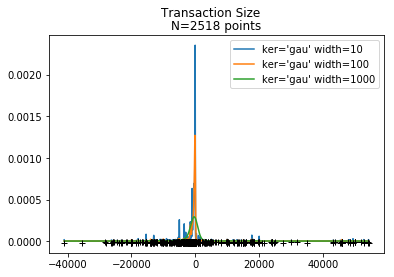

In [10]:
_ = density_model(tran_size,"Transaction Size", 
                  params=[(10, 'gaussian'),(100, 'gaussian'),(1000, 'gaussian')])

## Figure 2

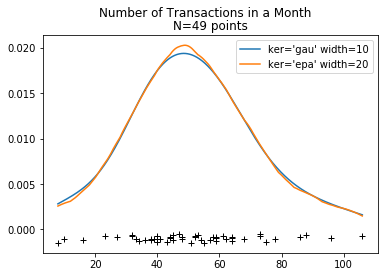

In [11]:
_ = density_model(n_tran,"Number of Transactions in a Month",
                              params=[(10, 'gaussian'),(20, 'epanechnikov')])

## Figure 3

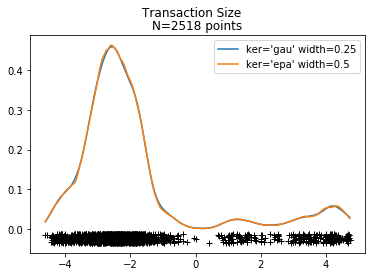

In [12]:
_ = density_model(tran_size_logged,"Transaction Size", 
                  params=[(0.25, 'gaussian'),(0.5, 'epanechnikov')])